Modèle additif, on essaie de capter la composante saisonniere avec une spline cyclique.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import GammaRegressor

In [28]:
def fct_scores_mse(Y_true, Y_pred, liste_stations):
    
    Y_true = Y_true.sort_values(by = ["Date"])
    Y_pred = Y_pred.sort_values(by = ["Date"])
    
    liste_mse = []
    for code in liste_stations:
        liste_mse.append(np.mean(np.square(Y_true[code] - Y_pred[code])))
    resultat = pd.DataFrame({"Code station": liste_stations, "MSE": liste_mse})
    return resultat

In [29]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base_journalier/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base_journalier/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base_journalier/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base_journalier/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base_journalier/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base_journalier/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

## Fonctions

### Calcul de la spline

In [30]:
def fct_Modele_SplineGamma_fit(mesures_train, liste_stations, n_knots):
    ## Fonction pour déterminer les splines cycliques, GAM gamma
    # mesures: dataframe X d'entrainement
    # n_knots: le nombre de noeuds
    
    mesures_stations = mesures_train[["Date"] + liste_stations]
    # On prend en abscisse le delta de temps par rapport au 01/01 de l'année en cours
    mesures_tofit = pd.DataFrame()
    liste_annee = np.unique(mesures_stations["Date"].apply(lambda x: x.year))
    for curr_annee in liste_annee:
        mesures_annee = mesures_stations[mesures_stations["Date"].apply(lambda x: x.year == curr_annee)]
        n_mesures = len(mesures_annee)
        mesures_annee.index = range(n_mesures)
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        jours_delta = (mesures_annee["Date"] - jour_an).apply(lambda x: x.delta)
        jours_delta.index = range(n_mesures)
        mesures_annee = pd.concat([mesures_annee, pd.DataFrame({"Delta": jours_delta})], axis = 1)
        mesures_tofit = pd.concat([mesures_tofit, mesures_annee])
    
    resultat = pd.DataFrame({"Delta": np.unique(mesures_tofit["Delta"])})
    # Calcul de la spline
    for code in liste_stations:
        X = mesures_tofit[["Delta", code]]
        spline = SplineTransformer(n_knots=n_knots,
                                   extrapolation="periodic")
        model = make_pipeline(spline, GammaRegressor(alpha = 0))
        model.fit(X[["Delta"]], X[code])
        composante = model.predict(resultat[["Delta"]])
        composante = pd.DataFrame(composante, columns = [code])
        resultat = pd.concat([resultat, composante], axis = 1)
    return resultat

In [31]:
def fct_Modele_SplineGamma_predict(fit, liste_dates, liste_stations):
    
    fit["Delta_Jour"] = fit.index
    max_jours = np.max(fit["Delta_Jour"])
    
    # On retourne la bonne valeur
    resultat = pd.DataFrame({"Date": liste_dates})
    liste_annees = np.unique(liste_dates.apply(lambda x: x.year))
    predictions = []
    for curr_annee in liste_annees:
        dates_annee = pd.DataFrame({"Date": liste_dates[liste_dates.apply(lambda x: x.year == curr_annee)]})
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        dates_annee["Delta_Jour"] = (dates_annee - jour_an)
        dates_annee["Delta_Jour"] = dates_annee["Delta_Jour"].apply(lambda x: x.days)
        for index, row in dates_annee.iterrows():
            predictions.append(fit[fit["Delta_Jour"] == row["Delta_Jour"]%(max_jours+1)][liste_stations].iloc[0,:])
    resultat[liste_stations] = predictions
    return resultat

# Validation croisée

In [32]:
max_n_knots = 25

for curr_n_knots in tqdm(range(4, max_n_knots+1)):
    # print("N knots: " + str(curr_n_knots))
    cv_scores = pd.DataFrame({"Code station": liste_stations})
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
    
        spline_fit = fct_Modele_SplineGamma_fit(curr_train_X, liste_stations, curr_n_knots)

        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        
        predictions_Y = fct_Modele_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
        # Score
        curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations)
        cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]

    cv_moyen = []
    for code in liste_stations:
        score = np.mean(cv_scores[cv_scores["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen.append(score)    
    cv_scores["Moyenne"] = cv_moyen
    cv_scores.to_csv("../Data/GAM_Gamma_Journalier/cv_n_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                     index=False)  

100%|██████████| 22/22 [02:28<00:00,  6.76s/it]


In [33]:
cv_moyen = pd.DataFrame()

cv_Naif = pd.read_csv("../Data/Naif_Journalier/CV_scores.csv")
curr_moyen = pd.DataFrame()
for code in liste_stations:
    curr_moyen[code] = list(cv_Naif[cv_Naif["Code station"] == code]["Moyenne"])
curr_moyen["Noeuds"] = 0
cv_moyen = pd.concat([cv_moyen, curr_moyen])

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma_Journalier/cv_n_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

In [34]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

Cours eau  Index Couleur
0   Garonne      0     red
1     Loire      1   green
2     Seine      2    blue

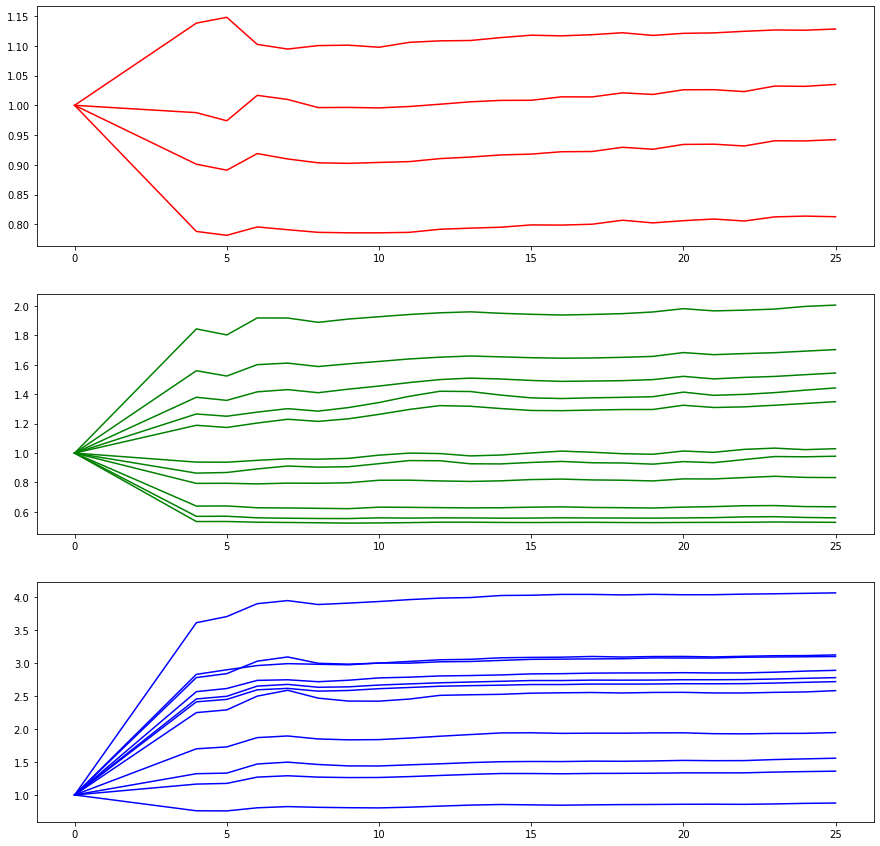

In [35]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,15))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code]/cv_moyen[code].iloc[0],
                   color = cours_eau_cmap(i))
plt.show()

# Test

In [36]:
n_knots = 10

In [37]:
liste_dates = mesures_test_Y["Date"]
spline_fit = fct_Modele_SplineGamma_fit(mesures_test_X, liste_stations, n_knots)
predictions_test_Y = fct_Modele_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
test_scores = fct_scores_mse(mesures_test_Y, predictions_test_Y, liste_stations)

In [38]:
test_scores.to_csv("../Data/GAM_Gamma_Journalier/Test_scores.csv",
                   index = False)
test_scores

Code station            MSE
0      O0200020     373.666376
1      O2620010   15602.525717
2      O6140010   57278.203101
3      O9000010  148690.053797
4      K0030020      11.801140
5      K0100020      26.137141
6      K0260020     224.414612
7      K0550010     923.044763
8      K0690010    1671.916013
9      K0910050    1726.007557
10     K4180010   10443.288391
11     K4350020    9647.867417
12     K6830020   15905.695469
13     L8000020   42578.412568
14     M5300010   98057.612271
15     H0100010       7.470131
16     H0100020      12.731647
17     H0400010     160.954112
18     H0400020      83.075609
19     H0800011      81.902594
20     H0800012      10.256258
21     H0810010     118.772079
22     H1700010     504.399832
23     H3930020    3142.722402
24     H4340020    3655.803212
25     H8100021   19344.575568

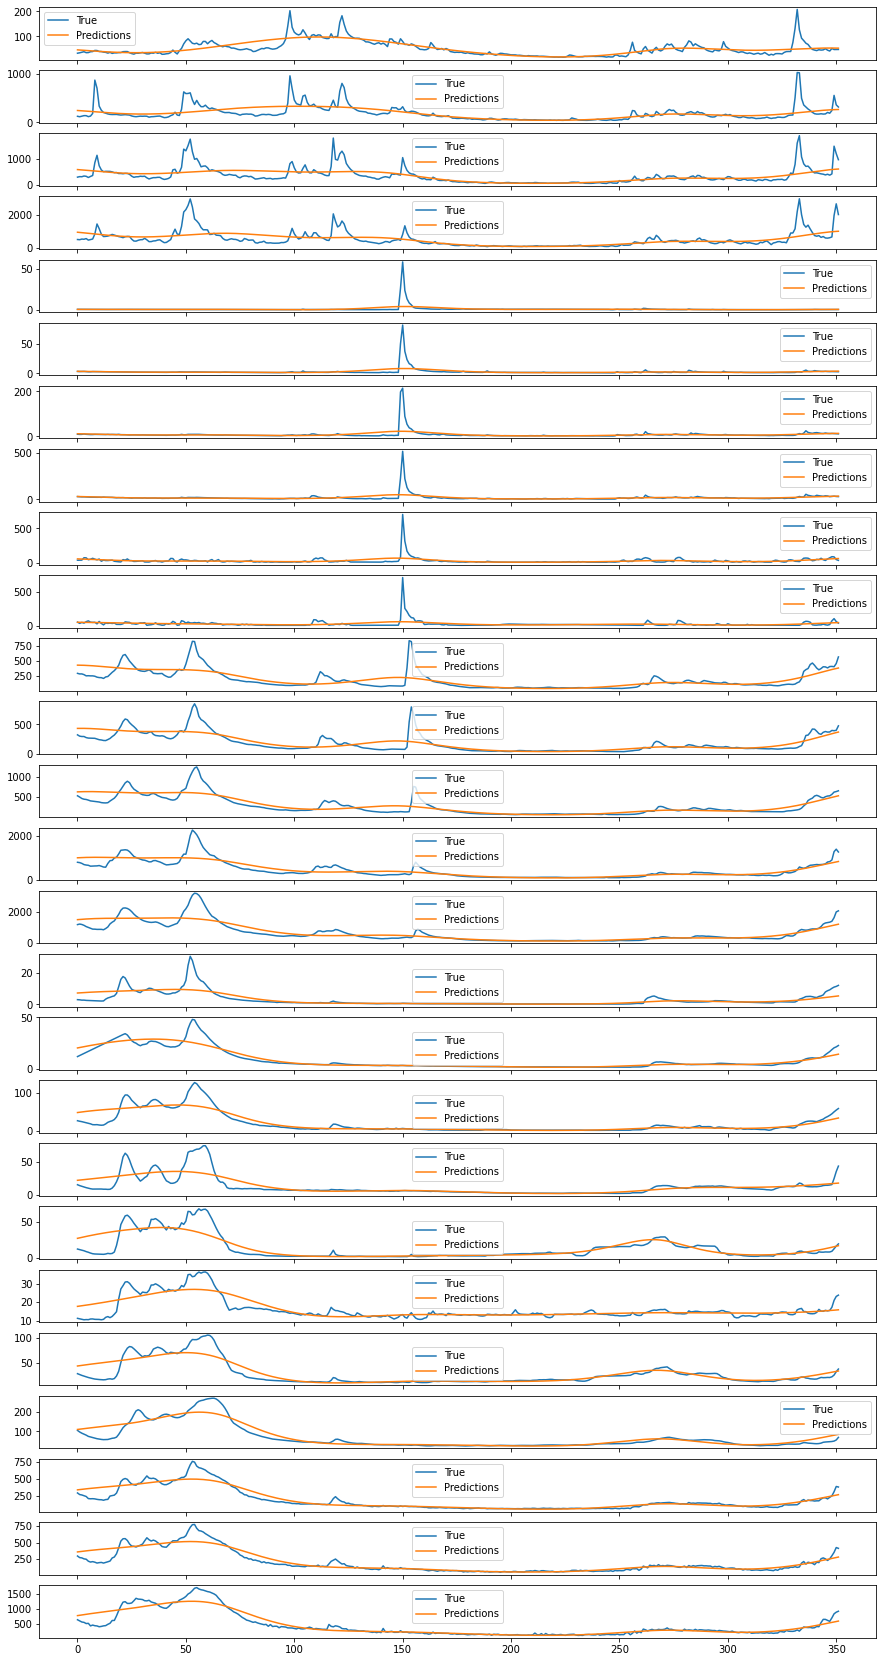

In [39]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()